In [5]:
import os.path as ospath
import numpy as np
# pytorch
import torch 
import torch.nn.functional as F # pytorch NN functional module
#pytorch modules
import torch_geometric.transforms as T
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
import pickle

Please note that in this notebook, the cached previous values are in eV but they will shown in kcal/mol if run again.

# Load DataSet  and preprocessing
Here we use the pytorch-Geometric dataset QM9.  

In [7]:
__file__ = 'dsgdb9nsd.xyz' # an example of a file name to extract the path of the QM dataset
path = ospath.join(ospath.dirname(ospath.realpath(__file__)), '..', 'data', 'QM9')
dataset = QM9(path) # we use in-built pytorch QM9 dataset

# Data Splitting and further processing
Random indices ( but always same) for the right comparsion of differnet models so that Training, Valiation and Test set remain always same

In [8]:
indices = np.random.RandomState(seed=42).permutation(len(dataset))
# OR
#with open('indices.pkl','rb') as f:
#    indices = pickle.load(f)

In [10]:
# Split datasets
batchsize = 128
target = 15 # index of atomisation energy (at 0K) in the list of 19 target values 

test_dataset = dataset[indices[0:10000]] # around 10% of complete data
val_dataset = dataset[indices[10000:20000]] # around 10% of complete data
train_dataset = dataset[indices[20000:]] # around 80% of complete data

### Normalisation of target values
Scaling of the target values of training data (atomisation energy) with mean=0 and std =1  
We will use the the the mean (tr_mean) and standard deviation (tr_std) of training data to calculate MAE for validation and test datapoints. 
The intension of doing normalistion of only traing dataset (not for whole dataset) is

1. to take test set as an held-out set   
2. to make our model more robust  
3. to stop information leakage to validation and test set.

In [11]:
tr_sum = 0
std_sum = 0
for i in range(len(train_dataset)):
     tr_sum += train_dataset[i].y[:,target]
tr_mean = (tr_sum / len(train_dataset)).item()


for i in range(len(train_dataset)):
    std_sum += (train_dataset[i].y[:,target] - tr_mean) ** 2
tr_std = np.sqrt(std_sum / len(train_dataset)).item()

In [12]:
for i in range(len(train_dataset)):
    train_dataset[i].y[:,target] = (train_dataset[i].y[:,target] - tr_mean) / tr_std

In [13]:
train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=batchsize, shuffle=False)

test_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)

### Creation of a new feature edge type
Trasformation of  edge_attr to a single dimension tensor of shape [num(edge_index)] to use in RGCNconv

In [14]:
#creation of edge_types for RGCNconv
train_edge_types, val_edge_types, test_edge_types = [], [], []

for i in range(len(train_dataset)):
    train_edge_types.append(np.argwhere(train_dataset[i].edge_attr == 1).T [:, 1].tolist())
flat_train_edge_types = [item for sublist in train_edge_types for item in sublist]

for i in range(len(val_dataset)):
    val_edge_types.append(np.argwhere(val_dataset[i].edge_attr == 1).T [:, 1].tolist())
flat_val_edge_types = [item for sublist in val_edge_types for item in sublist]

for i in range(len(test_dataset)):
    test_edge_types.append(np.argwhere(test_dataset[i].edge_attr == 1).T [:, 1].tolist())
flat_test_edge_types = [item for sublist in test_edge_types for item in sublist]

# About made dataset using pytorch-geometric
**x** : node `[num_atoms, num_features]`

**edge_index** : Graph connectivity in COO format
            with shape :`[2, num_edges]` 
    
**edge_attr**: Edge feature matrix with shape
            `[num_edges, num_edge_features]`.  
            
**y**: Graph-level or node-level ground-truth labels
            with arbitrary shape.
            
**pos**: Node position matrix with shape
            `[num_nodes, num_dimensions]`. 
            
The edge_index property holds the information about the graph connectivity, i.e., a tuple of source and destination node indices for each edge.

https://www.youtube.com/watch?v=Vz5bT8Xw6Dc  

https://www.youtube.com/watch?v=Q5T-JdyVCfs

In [11]:
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of type of regression targets: {dataset.num_classes}')
print('======================')
print(f'First graph (CH4 molecule) data structure: \n{dataset[0]}')
print('-------')
print(f'Edge_index in COO format of shape {dataset[0].edge_index.shape}: \n{dataset[0].edge_index}')
print('-------')
print(f'(CH4 molecule) edge_attr of shape {dataset[0].edge_attr.shape} which is [edge_index, num_relations/edge_types] : \n{dataset[0].edge_attr}')

Dataset: QM9(130831):
Number of graphs: 130831
Number of features: 11
Number of type of regression targets: 19
First graph (CH4 molecule) data structure: 
Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5])
-------
Edge_index in COO format of shape torch.Size([2, 8]): 
tensor([[0, 0, 0, 0, 1, 2, 3, 4],
        [1, 2, 3, 4, 0, 0, 0, 0]])
-------
(CH4 molecule) edge_attr of shape torch.Size([8, 4]) which is [edge_index, num_relations/edge_types] : 
tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]])


# Dataloader implementation

In [16]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import RGCNConv
from torch_geometric.nn import global_mean_pool

class RGCN(torch.nn.Module):
    
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = RGCNConv(in_channels=dataset.num_features, out_channels=hidden_channels, num_relations=4)
        self.conv2 = RGCNConv(in_channels=hidden_channels, out_channels=hidden_channels, num_relations=4)
        self.conv3 = RGCNConv(in_channels=hidden_channels, out_channels=hidden_channels, num_relations=4)
        self.lin1 = nn.Linear(in_features=hidden_channels, out_features=64)
        self.lin2 = nn.Linear(in_features=64, out_features=1)
        
    def forward(self, x, edge_index, edge_type, batch):
        
        # 1. node embeddings
        x = self.conv1(x, edge_index, edge_type )
        x = F.relu(x)
       
        x = self.conv2(x, edge_index, edge_type)
        x = F.relu(x)
        
        x = self.conv3(x, edge_index, edge_type)
        x = F.relu(x)
        
        
        # 2. Readout layer used for graph level prediction ( 128, 64 )
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]
        
        
        # Linear layers
        x = F.relu(self.lin1(x))
        F.dropout(x, p=0.5, training=True)
        x = self.lin2(x)
        return x.view(-1)
        
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RGCN(hidden_channels=128).to(device)
print(model)

RGCN(
  (conv1): RGCNConv(11, 128, num_relations=4)
  (conv2): RGCNConv(128, 128, num_relations=4)
  (conv3): RGCNConv(128, 128, num_relations=4)
  (lin1): Linear(in_features=128, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=1, bias=True)
)


In [20]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                       factor=0.7, patience=5,
                                                       min_lr=0.00001)
criterian = nn.L1Loss()
current_epoch = 0 
loss_epoch_trn_list, loss_epoch_val_list, MAE_epoch_val_list = [], [], [] # loss storage lists

for epoch in range(300):
    current_epoch = epoch + 1
    running_trn_loss, running_batch_trn_loss = 0.0 , 0.0
    print(f"\nEpoch {epoch+1}\n-------------------------------")
  
  #__________________#
  # TRAINING
  #__________________#

    model.train()
    for dt in train_loader:
        dt.to(device)
        edge_type_lengths = dt.edge_index.shape[1]
        edge_types = torch.Tensor(flat_train_edge_types[:edge_type_lengths]).int()
    
        # Single forward pass 
        pred = model(dt.x, dt.edge_index, edge_types, dt.batch)
        
        # Compute the loss
        #loss = F.mse_loss(pred, dt.y[:,target])
        #loss = (pred * std - dv.y[:,target] * std).abs().sum().item()
        loss = criterian(pred, dt.y[:,target])
        # backpropogation 
        loss.backward() # Derive gradients
        optimizer.step() # Update parameters based on gradients
        optimizer.zero_grad() # zeroes the gradients
    
        # statistics
        running_trn_loss += loss.item()
        running_batch_trn_loss += loss.item() 
        
    # cummulative training loss after each epoch
    loss_epoch_trn_list.append(running_trn_loss / len(train_dataset))
    #print(f"Training MSE loss: {loss_epoch_trn_list[-1]:>7f}")
    print(f"Training MAE loss: {running_trn_loss / len(train_dataset):>7f}")
  
  #_____________#
  # VALIDATION
  #_____________#

    model.eval()
    running_val_loss, error = 0, 0
  
    with torch.no_grad():
        for dv in val_loader:
            dv.to(device)
            edge_type_lengths = dv.edge_index.shape[1]
            edge_types = torch.Tensor(flat_val_edge_types[:edge_type_lengths]).int()
            
            pred = model(dv.x, dv.edge_index, edge_types, dv.batch)
            
            #val_loss = F.mse_loss(pred, dv.y[:,target])
            #val_loss = criterian(pred, dv.y[:,target])
            #running_val_loss += val_loss.item()
            error += (pred * tr_std + tr_mean - dv.y[:,target]).abs().sum().item()  # MAE
    
    scheduler.step(error)
    MAE_epoch_val_list.append(error / len(val_dataset))
    #loss_epoch_val_list.append(running_val_loss/ len(val_dataset)) # append to list
    print(f"validation MAE: {running_val_loss / len(val_dataset):>7f}")
    print(f'MAE in validation: {error / len(val_dataset):.7f}')
            

    #saving model for minimum validation loss
    if MAE_epoch_val_list[-1] <= min(MAE_epoch_val_list):
        print("model saved\n")
        torch.save(model, './best_128_3RGCN.pth')


Epoch 1
-------------------------------
Training MAE loss: 0.002161
validation MAE: 0.558741
MAE in validation: 2.2113697
model saved


Epoch 2
-------------------------------
Training MAE loss: 0.001848
validation MAE: 0.558313
MAE in validation: 2.1630418
model saved


Epoch 3
-------------------------------
Training MAE loss: 0.001804
validation MAE: 0.558727
MAE in validation: 2.1408611
model saved


Epoch 4
-------------------------------
Training MAE loss: 0.001772
validation MAE: 0.558732
MAE in validation: 2.1207635
model saved


Epoch 5
-------------------------------
Training MAE loss: 0.001743
validation MAE: 0.558503
MAE in validation: 2.0382329
model saved


Epoch 6
-------------------------------
Training MAE loss: 0.001732
validation MAE: 0.558426
MAE in validation: 2.0141648
model saved


Epoch 7
-------------------------------
Training MAE loss: 0.001704
validation MAE: 0.558336
MAE in validation: 2.0197657

Epoch 8
-------------------------------
Training MAE loss: 0

Training MAE loss: 0.001428
validation MAE: 0.558420
MAE in validation: 1.7687116

Epoch 65
-------------------------------
Training MAE loss: 0.001411
validation MAE: 0.558533
MAE in validation: 1.7100575
model saved


Epoch 66
-------------------------------
Training MAE loss: 0.001409
validation MAE: 0.558712
MAE in validation: 1.7144162

Epoch 67
-------------------------------
Training MAE loss: 0.001404
validation MAE: 0.558677
MAE in validation: 1.7538481

Epoch 68
-------------------------------
Training MAE loss: 0.001399
validation MAE: 0.558667
MAE in validation: 1.6842328
model saved


Epoch 69
-------------------------------
Training MAE loss: 0.001400
validation MAE: 0.558629
MAE in validation: 1.6793962
model saved


Epoch 70
-------------------------------
Training MAE loss: 0.001400
validation MAE: 0.558643
MAE in validation: 1.6794130

Epoch 71
-------------------------------
Training MAE loss: 0.001398
validation MAE: 0.558662
MAE in validation: 1.6830878

Epoch 72
-

Training MAE loss: 0.001322
validation MAE: 0.558644
MAE in validation: 1.6213374

Epoch 129
-------------------------------
Training MAE loss: 0.001323
validation MAE: 0.558760
MAE in validation: 1.6278887

Epoch 130
-------------------------------
Training MAE loss: 0.001314
validation MAE: 0.558681
MAE in validation: 1.5931511
model saved


Epoch 131
-------------------------------
Training MAE loss: 0.001315
validation MAE: 0.558667
MAE in validation: 1.6004815

Epoch 132
-------------------------------
Training MAE loss: 0.001312
validation MAE: 0.558638
MAE in validation: 1.5947256

Epoch 133
-------------------------------
Training MAE loss: 0.001312
validation MAE: 0.558646
MAE in validation: 1.5951805

Epoch 134
-------------------------------
Training MAE loss: 0.001314
validation MAE: 0.558694
MAE in validation: 1.5909201
model saved


Epoch 135
-------------------------------
Training MAE loss: 0.001313
validation MAE: 0.558709
MAE in validation: 1.5975169

Epoch 136
------

Training MAE loss: 0.001288
validation MAE: 0.558713
MAE in validation: 1.5764497

Epoch 194
-------------------------------
Training MAE loss: 0.001289
validation MAE: 0.558678
MAE in validation: 1.5755174

Epoch 195
-------------------------------
Training MAE loss: 0.001291
validation MAE: 0.558697
MAE in validation: 1.5750492

Epoch 196
-------------------------------
Training MAE loss: 0.001290
validation MAE: 0.558705
MAE in validation: 1.5754510

Epoch 197
-------------------------------
Training MAE loss: 0.001289
validation MAE: 0.558676
MAE in validation: 1.5752088

Epoch 198
-------------------------------
Training MAE loss: 0.001288
validation MAE: 0.558700
MAE in validation: 1.5740011

Epoch 199
-------------------------------
Training MAE loss: 0.001290
validation MAE: 0.558713
MAE in validation: 1.5750990

Epoch 200
-------------------------------
Training MAE loss: 0.001290
validation MAE: 0.558693
MAE in validation: 1.5737277

Epoch 201
-------------------------------


validation MAE: 0.558689
MAE in validation: 1.5728560

Epoch 259
-------------------------------
Training MAE loss: 0.001288
validation MAE: 0.558690
MAE in validation: 1.5738409

Epoch 260
-------------------------------
Training MAE loss: 0.001288
validation MAE: 0.558700
MAE in validation: 1.5728176

Epoch 261
-------------------------------
Training MAE loss: 0.001287
validation MAE: 0.558682
MAE in validation: 1.5725697
model saved


Epoch 262
-------------------------------
Training MAE loss: 0.001287
validation MAE: 0.558699
MAE in validation: 1.5726529

Epoch 263
-------------------------------
Training MAE loss: 0.001287
validation MAE: 0.558678
MAE in validation: 1.5727870

Epoch 264
-------------------------------
Training MAE loss: 0.001288
validation MAE: 0.558706
MAE in validation: 1.5734099

Epoch 265
-------------------------------
Training MAE loss: 0.001287
validation MAE: 0.558691
MAE in validation: 1.5727501

Epoch 266
-------------------------------
Training MAE lo

KeyboardInterrupt: 

NameError: name 'loss_epoch_trn_list' is not defined

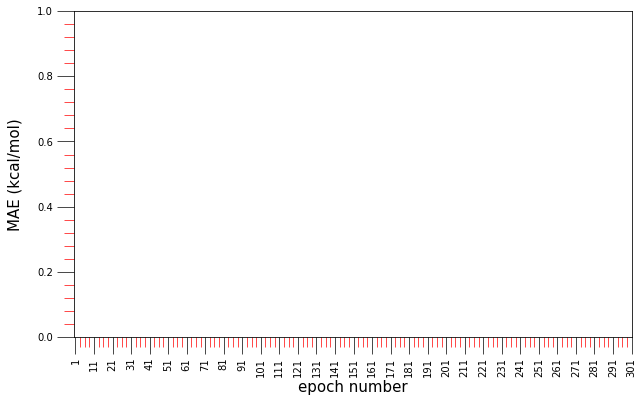

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
fig,ax = plt.subplots(figsize=(10, 6))
x_points = np.arange(1, 299+2, 1 )
x_points_ = np.arange(1, 299+3, 10 )
ax.set_xticks(x_points_)
plt.xticks(rotation=90)
ax.set_xlabel('epoch number',fontsize=15, labelpad =3)
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.tick_params(which='major', width=0.7,length=17,direction="out" , labelleft=True )
ax.tick_params(which='minor', width=0.7, length=10, color='r', direction="out")
ax.set_ylabel('MAE (kcal/mol)',fontsize=15, labelpad=15)
ax.plot(x_points, np.array(loss_epoch_trn_list) * tr_std * 23.06 , color = 'black', marker='o', markersize=5 , linestyle='dashed', dashes=(15, 10),linewidth=0.2) 
# 23.06 1ev = 23.06 kcal/mol
ax.legend(['Training loss [128-dim 3layer RGCN]'], loc='best', fontsize=15, frameon=False)
plt.savefig("H_128_3Layer_training_RGCN.png")
plt.show()
# Please note that above code will run successfully. The Traing graph is not shown this time because of session variable problem.

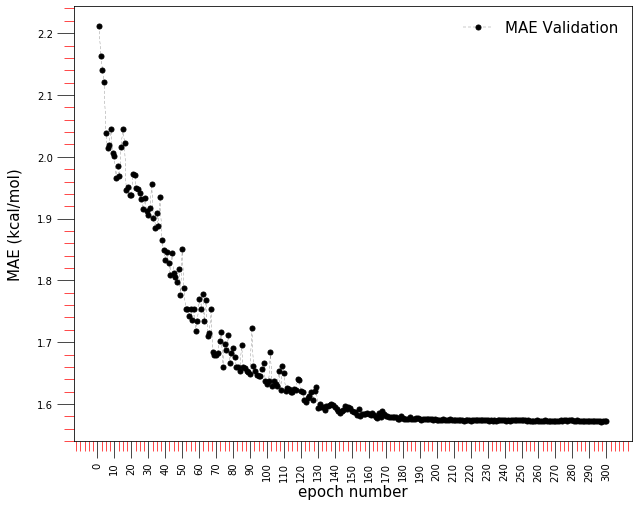

In [22]:

fig,ax = plt.subplots(figsize=(10, 6))
x_points = np.arange(1, 299+2, 1 )
x_points_ = np.arange(0, 299+3, 10 )
ax.set_xticks(x_points_)
ax.set_xlabel('epoch number',fontsize=15, labelpad =3)
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.xticks(rotation=90)
ax.tick_params(which='major', width=0.7,length=17,direction="out" , labelleft=True )
ax.tick_params(which='minor', width=0.7, length=10, color='r', direction="out")
ax.set_ylabel('MAE (kcal/mol)',fontsize=15, labelpad=15)
ax.plot(x_points, np.array(MAE_epoch_val_list) * 23.06 , color = 'black', marker='o', markersize=5 , linestyle='dashed', dashes=(15, 10),linewidth=0.2) 
#ax.plot(x_points, loss_epoch_val_list , color = 'black', marker='v', markersize=5 , linestyle='solid', linewidth=0.2) 
ax.legend(['Validation Loss [128-dim 3 Layer RGCN]'], loc='best', fontsize=15, frameon=False)
plt.savefig("MAE_128_3Layer_RGCN_validation.png")
plt.show()

# min 64 Drop 1.9450273399353026
# min 16 Drop 2.135177117538452
# min 16 no drop 2.1192333839416504

#The below graph values are in eV, kcal/ mol is incorrectly showing. When rerun, it will show correct

# Evaluation

In [23]:
#validation error
min(MAE_epoch_val_list[0:300]) 

1.5716194236755372

In [17]:
#load model and continue training
PATH = './best_128_3RGCN.pth'
our_saved_model = torch.load(PATH)

In [20]:
error = 0
actual_values = []
predicted_values = []
our_saved_model.eval()
with torch.no_grad():
    for dtest in test_loader:
        dtest = dtest.to(device)
        edge_type_lengths = dtest.edge_index.shape[1]
        edge_types = torch.Tensor(flat_test_edge_types[:edge_type_lengths]).int()
        pred = model(dtest.x, dtest.edge_index, edge_types, dtest.batch)
        predicted_values.append(pred * tr_std + tr_mean)
        actual_values. append(dtest.y[:,target])
        error += (pred * tr_std + tr_mean - dtest.y[:,target]).abs().sum().item()  # MAE
    mae_test_set = error / len(test_loader.dataset) * 23.06
    print(f"MAE Test Set: {mae_test_set:>7f}")

MAE Test Set: 7.616381


In [30]:
m = []
for each in actual_values:
    each = m.append(each.tolist())
actual_ = np.array([item for sublist in m for item in sublist])  * 23.06

n = []
for each in predicted_values:
    each = n.append(each.tolist())
pred_ = np.array([item for sublist in n for item in sublist]) * 23.06

# evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
rmse = np.sqrt(mean_squared_error(actual_, pred_))

In [34]:
# utility Functions
def plot_pred_actual(y_true, y_predict,r2, mae, test_num_atoms, rmse):
    """ Plots Predicted energy vs actual energy for input data
    
    Parameters
    ----------
    y_true: 1-d ndarray
            Actual energy
    y_predict: 1-d ndarray
               prediction energy
    r2: float
        r2_score value
    mae : float
          MAE value
    """
    
    x_min = np.min(np.concatenate((y_true , y_predict)))
    x_max = np.max(np.concatenate((y_true, y_predict)))
    line = np.linspace(x_min, x_max, 10)
    plt.plot(line, line,  c='r')

    ax = plt.subplot(1,1,1)
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([x_min, x_max])
    im = ax.scatter(y_predict , y_true , marker='.', c=test_num_atoms)
    plt.xlabel('Actual energy (kcal/mol)')
    plt.ylabel('Predicted energy (kcal/mol)')
    cbar = plt.colorbar(im)
    cbar.ax.set_ylabel('# of atoms in a molecule', rotation=90)
    plt.title(f'3-Layer RGCN 128 hidden features \nr2_score :{r2:5.3f}, MAE: {mae:5.3f}, RMSE:{rmse:5.3f}')
    plt.savefig('RGCN_300_128_epoch_pred_vs_actual.png')
    plt.show()

In [36]:
num_atoms = []
for i in range(len(dataset)):
    num_atoms.append(dataset[i].pos.shape[0])
num_atoms = np.array(num_atoms)
train_num_atoms = num_atoms[indices[20000:]]
val_num_atoms = num_atoms[indices[10000:20000]]
test_num_atoms = num_atoms[indices[0:10000]]

dsgdb9nsd.xyz:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


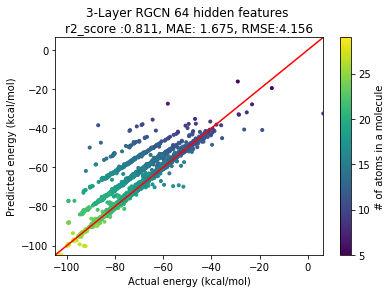

In [37]:
r2 = r2_score(actual_, pred_)
plot_pred_actual(actual_, pred_, r2, mae_test_set, test_num_atoms, rmse)